## Data Gathering


In [1]:
# Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import requests

# To unzip the edf_dataset
import zipfile
import os

# EDFlib and Data Preprocesing module
from mne.preprocessing import ICA, create_eog_epochs
import mne
from pyedflib import highlevel
import pyedflib as plib

In [2]:
import requests


def download_file(url, save_path):

    # Check if the file already exists
    if os.path.exists(save_path):
        print(f"File already exists at '{save_path}'. Skipping download.")
        return  # Exit the function if the file exists

    # Send a GET request to the URL
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Open the file in binary write mode and save the content
        with open(save_path, 'wb') as file:
            file.write(response.content)
        print(f"File downloaded successfully and saved to '{save_path}'")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")


# Specify the URL and the path where you want to save the file
url = 'https://figshare.com/ndownloader/articles/4244171/versions/2'
# Change this to your desired path
save_path = './edf_dataset.zip'

# Call the function to download the file
download_file(url, save_path)

File already exists at './edf_dataset.zip'. Skipping download.


In [3]:
def unzip_file(zip_file_path, extract_to_folder):

    # Check if the directory exist
    
    if os.path.exists(extract_to_folder):
        print(f"Directory '{extract_to_folder} already exists")
        return # Exit the function if the directory
    
    # Create the directory if it doesn't exist
    os.makedirs(extract_to_folder, exist_ok=True)

    # Open the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all the contents into the specified folder
        zip_ref.extractall(extract_to_folder)


# Specify the path to the zip file and the extraction folder
zip_file_path = './edf_dataset.zip'
# Change this if needed
extract_to_folder = './edf_dataset_2'

# Call the function to unzip
unzip_file(zip_file_path, extract_to_folder)


Directory './edf_dataset_2 already exists


In [4]:
import os
import re

edf_directory = "./edf_dataset_2"

for filename in os.listdir(edf_directory):
    new_filename = filename
    
    # Handle spaces in filename
    if ' ' in new_filename:
        new_filename = re.sub(r'\s+', '_', new_filename)
    
    # Handle subject numbers (S1 -> S01)
    new_filename = re.sub(r'S(\d)(?!\d)', r'S0\1', new_filename)
    
    # Handle filenames containing '6931959'
    if '6931959' in new_filename:
        new_filename = new_filename.replace('6931959_', '')
    
    # Handle filenames containing '6921143'
    if '6921143' in new_filename:
        new_filename = new_filename.replace('6921143_', '')
    
    # Zero-pad other single-digit numbers in filenames
    new_filename = re.sub(r'(?<!\d)(\d)(?!\d)', r'0\1', new_filename)
    
    # Only rename if the filename has changed
    if new_filename != filename:
        old_file = os.path.join(edf_directory, filename)
        new_file = os.path.join(edf_directory, new_filename)
        
        os.rename(old_file, new_file)
        print(f'Renamed: "{filename}" to "{new_filename}"')

print("Renaming complete.")

Renaming complete.


## Individual Preprocessing Functions


In [5]:
# Function to rename channels and drop specified channels based on conditions
def process_channels(raw_data):
    """
    Process and standardize EEG channels to keep only the 17 most common channels.
    """
    print(f"Initial channels: {raw_data.ch_names}")

    # Initialize a list to hold channels to drop
    channels_to_drop = []

    # Create mapping for channel renaming
    rename_map = {}
    for name in raw_data.ch_names:
        if any(x in name for x in ['23A-23R', '24A-24R', 'A2-A1']):
            channels_to_drop.append(name)
        else:
            new_name = name.replace('EEG ', '').replace('-LE', '')
            rename_map[name] = new_name

    # Drop unwanted channels
    if channels_to_drop:
        print(f"Dropping channels: {channels_to_drop}")
        raw_data.drop_channels(channels_to_drop)

    # Rename remaining channels
    raw_data.rename_channels(rename_map)

    print(f"Final channels: {raw_data.ch_names}")

    # Define the 17 most common channels
    expected_channels = [
        'Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'Fp2',
        'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz'
    ]

    # Keep only the expected channels
    channels_to_keep = set(expected_channels)
    channels_to_drop = [
        ch for ch in raw_data.ch_names if ch not in channels_to_keep]

    if channels_to_drop:
        print(
            f"Dropping channels to keep only the expected 17 channels: {channels_to_drop}")
        raw_data.drop_channels(channels_to_drop)

    # Verify we have the expected number of channels (should be 17)
    if len(raw_data.ch_names) != len(expected_channels):
        print(
            f"Warning: Expected {len(expected_channels)} channels, got {len(raw_data.ch_names)}")
        print(f"Missing: {set(expected_channels) - set(raw_data.ch_names)}")

    return raw_data

In [6]:
all_edf_files = os.listdir(edf_directory)
ec_file_path = [i for i in all_edf_files if i.endswith('EC.edf')]
eo_file_path = [i for i in all_edf_files if i.endswith('EO.edf')]
task_file_path = [i for i in all_edf_files if i.endswith('TASK.edf')]

print(len(all_edf_files), len(ec_file_path), len(eo_file_path), len(task_file_path))

180 58 61 61


In [7]:
def read_data(file_path):
    data = mne.io.read_raw_edf(file_path, preload=True)
    data.set_eeg_reference()
    return data
    

In [8]:
def bandpass_filter(data, l_freq, h_freq):
    # Adjust the filter parameters as needed
    data.filter(l_freq=l_freq, h_freq=h_freq)

In [9]:
def preprocess_ICA(raw, n_components ):
    print(f"Preprocessing ICA: {raw.filenames}")

    ica = ICA(n_components=n_components,random_state=97,
              max_iter=800) 
    ica.fit(raw)
    return ica

In [10]:
def create_epochs(processed_data, duration=5.0, overlap=1.0):
    """
    Create epochs from continuous EEG data and format for CNN input
    
    Parameters:
    -----------
    processed_data : mne.io.Raw
        The raw EEG data
    duration : float
        Duration of each epoch in seconds
    overlap : float
        Overlap between epochs in seconds
    
    Returns:
    --------
    epochs_array : numpy.ndarray
        The epoched data formatted for CNN (samples, channels, timepoints, 1)
    """

    # Create epochs
    epochs = mne.make_fixed_length_epochs(
        processed_data,
        duration=duration,
        overlap=overlap,
        preload=True
    )

    # Drop bad epochs
    epochs.drop_bad()

    # Get data and reshape for CNN
    # Shape will be (n_epochs, n_channels, n_timepoints)
    data = epochs.get_data()

    # Add channel dimension for CNN: (n_epochs, n_channels, n_timepoints, 1)
    data = data[..., np.newaxis]

    return data

In [ ]:
# Directory containing the EDF files
edf_directory = "./edf_dataset_2"  # Adjust this path to your dataset location

# Initialize lists
processed_raw_data = []
class_counts = {'Healthy': 0, 'MDD': 0}

# Read all EDF files
for filename in os.listdir(edf_directory):
    if filename.endswith('.edf'):
        file_path = os.path.join(edf_directory, filename)
        try:
            # Read the raw data
            raw_data = read_data(file_path)

            if raw_data is not None:
                processed_raw_data.append(raw_data)
                print(f"Successfully loaded: {filename}")
            else:
                print(f"Failed to load: {filename}")

        except Exception as e:
            print(f"Error loading {filename}: {str(e)}")
            continue

print(f"\nTotal files loaded: {len(processed_raw_data)}")

## Full Preprocessing Function


In [22]:
def preprocess_eeg(raw_data, l_freq, h_freq, n_components, 
                   time_steps, samples_per_step, overlap_seconds):
    """
    Complete EEG preprocessing pipeline with configurable epoch overlap
    """
    try:
        print(f"\nProcessing file: {raw_data.filenames}")
        
        processed_raw = process_channels(raw_data=raw_data)

        # 1. Bandpass filtering
        print("1. Applying bandpass filter...")
        bandpass_filter(processed_raw, l_freq, h_freq)

        # 2. ICA
        print("2. Applying ICA...")
        ica = preprocess_ICA(processed_raw, n_components)
        ica.apply(processed_raw)

        # 3. Normalization (Critical fix: Store normalized data)
        print("3. Normalizing data...")
        data = processed_raw.get_data()
        epsilon = 1e-10
        data = (data - np.mean(data, axis=1, keepdims=True)) / (np.std(data, axis=1, keepdims=True) + epsilon)
        processed_raw._data = data  # Update raw object with normalized data

        # 4. Reshape with overlap
        print("4. Reshaping data with overlap...")
        n_channels = data.shape[0]
        sampling_rate = processed_raw.info['sfreq']
        
        total_samples = time_steps * samples_per_step
        overlap_samples = int(overlap_seconds * sampling_rate)
        step_size = total_samples - overlap_samples
        
        reshaped_data = []
        for start in range(0, data.shape[1] - total_samples + 1, step_size):
            end = start + total_samples
            sequence = data[:, start:end]
            
            # Reshape and transpose
            sequence = sequence.reshape(time_steps, n_channels, samples_per_step)
            sequence = np.transpose(sequence, (0, 2, 1))  # (time_steps, samples, channels)
            
            reshaped_data.append(sequence)

        final_data = np.array(reshaped_data)[..., np.newaxis]
        print(f"Reshaped data with {overlap_seconds}s overlap. Final shape: {final_data.shape}")
        return final_data

    except Exception as e:
        print(f"Preprocessing error: {str(e)}")
        return None


## Preprocessing


In [ ]:
# Now process each raw data file
X_data = []
y_labels = []
class_counts = {'Healthy': 0, 'MDD': 0}

print("\nStarting preprocessing pipeline...")
for raw_data in processed_raw_data:
    filename = os.path.basename(raw_data.filenames[0])
    print(f"\n{'='*50}")
    print(f"Processing: {filename}")
    print(f"Initial data info:")
    print(f"Channels: {raw_data.ch_names}")
    print(f"Sample rate: {raw_data.info['sfreq']} Hz")
    print(f"Duration: {raw_data.n_times / raw_data.info['sfreq']:.2f} seconds")

    # Apply complete preprocessing pipeline
    try:
        # First, process the channels
        # Make a copy to prevent modifying original
        raw_data = process_channels(raw_data.copy()) 
        print(f"Channels after processing: {raw_data.ch_names}")

        # Apply complete preprocessing pipeline
        processed_data = preprocess_eeg(
            raw_data, l_freq=0.5, h_freq=50.0, n_components=5, time_steps=5, samples_per_step=256, overlap_seconds=1
        )

        if processed_data is not None:
            print(f"Processed data shape: {processed_data.shape}")

            # Create label (1 for MDD, 0 for Healthy)
            label = 1 if filename.startswith('MDD') else 0

            # Update counts with number of epochs
            if label == 1:
                class_counts['MDD'] += processed_data.shape[0]
            else:
                class_counts['Healthy'] += processed_data.shape[0]

            # Append to lists
            X_data.append(processed_data)
            y_labels.extend([label] * processed_data.shape[0])
            print(f"Successfully processed {filename}")
        else:
            print(f"Failed to process {filename}")

    except Exception as e:
        print(f"Error processing {filename}: {str(e)}")
        continue

    print(f"{'='*50}\n")


# Print final summary
print("\nProcessing Summary:")
print(f"Total files processed: {len(processed_raw_data)}")
print(f"Total epochs: {len(y_labels)}")
print(f"Successfully processed files: {len(X_data)}")
print(f"Failed files: {len(processed_raw_data) - len(X_data)}")
print("\nClass distribution:")
print(f"MDD epochs: {class_counts['MDD']}")
print(f"Healthy epochs: {class_counts['Healthy']}")

In [25]:
# Check if we have any processed data
if len(X_data) > 0:
    try:
        # Print shapes before concatenation
        print("\nArray shapes before concatenation:")
        for i, arr in enumerate(X_data):
            print(f"Array {i}: shape {arr.shape}")

        # Concatenate data
        X = np.concatenate(X_data, axis=0)
        y = np.array(y_labels)

        # Print final information
        print("\nFinal Dataset Information:")
        print(f"Total samples: {len(X)}")
        print(f"Healthy samples: {class_counts['Healthy']}")
        print(f"MDD samples: {class_counts['MDD']}")
        print(f"Input shape: {X.shape}")
        print(f"Labels shape: {y.shape}")

        # Print channel information
        print(f"\nChannels used: {raw_data.ch_names}")

        # Print class balance
        total_epochs = class_counts['MDD'] + class_counts['Healthy']
        print("\nClass balance:")
        print(f"MDD: {(class_counts['MDD']/total_epochs)*100:.2f}%")
        print(f"Healthy: {(class_counts['Healthy']/total_epochs)*100:.2f}%")

    except Exception as e:
        print(f"\nError during final processing: {str(e)}")
        print("Checking individual arrays for inconsistencies...")

        # Find arrays with different shapes
        base_shape = X_data[0].shape[1:]
        for i, arr in enumerate(X_data):
            if arr.shape[1:] != base_shape:
                print(
                    f"Mismatch at index {i}: expected {base_shape}, got {arr.shape[1:]}")
else:
    print("\nNo data was successfully processed!")


Array shapes before concatenation:
Array 0: shape (74, 5, 256, 17, 1)
Array 1: shape (87, 5, 256, 17, 1)
Array 2: shape (151, 5, 256, 17, 1)
Array 3: shape (75, 5, 256, 17, 1)
Array 4: shape (75, 5, 256, 17, 1)
Array 5: shape (151, 5, 256, 17, 1)
Array 6: shape (75, 5, 256, 17, 1)
Array 7: shape (76, 5, 256, 17, 1)
Array 8: shape (151, 5, 256, 17, 1)
Array 9: shape (75, 5, 256, 17, 1)
Array 10: shape (73, 5, 256, 17, 1)
Array 11: shape (151, 5, 256, 17, 1)
Array 12: shape (75, 5, 256, 17, 1)
Array 13: shape (77, 5, 256, 17, 1)
Array 14: shape (152, 5, 256, 17, 1)
Array 15: shape (75, 5, 256, 17, 1)
Array 16: shape (75, 5, 256, 17, 1)
Array 17: shape (152, 5, 256, 17, 1)
Array 18: shape (88, 5, 256, 17, 1)
Array 19: shape (75, 5, 256, 17, 1)
Array 20: shape (151, 5, 256, 17, 1)
Array 21: shape (75, 5, 256, 17, 1)
Array 22: shape (75, 5, 256, 17, 1)
Array 23: shape (152, 5, 256, 17, 1)
Array 24: shape (75, 5, 256, 17, 1)
Array 25: shape (75, 5, 256, 17, 1)
Array 26: shape (150, 5, 256, 

## Model Definition


In [26]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, LSTM, Dropout, Flatten, Reshape, TimeDistributed

def create_2dcnn_lstm_model(input_shape=(5, 256, 17, 1)):
    inputs = Input(shape=input_shape)
    
    # TimeDistributed CNN layers to process each time step
    x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'))(inputs)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    
    x = TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    
    x = TimeDistributed(Conv2D(256, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    
    # Flatten CNN output while preserving time steps
    x = TimeDistributed(Flatten())(x)
    
    # LSTM layers
    x = LSTM(128, return_sequences=True)(x)
    x = LSTM(64)(x)
    
    # Dense layers
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    # Output layer
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

## Train Test Split


In [27]:
from sklearn.model_selection import train_test_split

def prepare_data(X_data, y_labels):
    # Combine all data
    X = np.concatenate(X_data, axis=0)
    y = np.array(y_labels)
    
    # Normalize the data
    X = (X - X.mean()) / X.std()
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    return X_train, X_test, y_train, y_test

In [28]:
def train_model(model, X_train, y_train, X_test, y_test):
    # Compile model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    
    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=5, restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6
        )
    ]
    
    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=25,
        batch_size=32,
        callbacks=callbacks
    )
    
    return history

## Performance Metrics


In [29]:
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Training predictions
    y_train_pred = model.predict(X_train)
    y_train_pred_classes = (y_train_pred > 0.5).astype(int)
    
    # Test predictions
    y_test_pred = model.predict(X_test)
    y_test_pred_classes = (y_test_pred > 0.5).astype(int)
    
    # Calculate training metrics
    train_accuracy = accuracy_score(y_train, y_train_pred_classes)
    train_precision = precision_score(y_train, y_train_pred_classes)
    train_recall = recall_score(y_train, y_train_pred_classes)
    train_f1 = f1_score(y_train, y_train_pred_classes)
    train_auc = roc_auc_score(y_train, y_train_pred)
    
    # Calculate test metrics
    test_accuracy = accuracy_score(y_test, y_test_pred_classes)
    test_precision = precision_score(y_test, y_test_pred_classes)
    test_recall = recall_score(y_test, y_test_pred_classes)
    test_f1 = f1_score(y_test, y_test_pred_classes)
    test_auc = roc_auc_score(y_test, y_test_pred)
    
    # Print results
    print("\nTraining Results:")
    print(f"Accuracy: {train_accuracy:.4f}")
    print(f"Precision: {train_precision:.4f}")
    print(f"Recall: {train_recall:.4f}")
    print(f"F1-Score: {train_f1:.4f}")
    print(f"AUC-ROC: {train_auc:.4f}")
    
    print("\nTest Results:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall: {test_recall:.4f}")
    print(f"F1-Score: {test_f1:.4f}")
    print(f"AUC-ROC: {test_auc:.4f}")
    
    # Plot confusion matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Training confusion matrix
    cm_train = confusion_matrix(y_train, y_train_pred_classes)
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens', ax=ax1)
    ax1.set_title('Training Confusion Matrix')
    ax1.set_ylabel('True Label')
    ax1.set_xlabel('Predicted Label')
    
    # Testing confusion matrix
    cm_test = confusion_matrix(y_test, y_test_pred_classes)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=ax2)
    ax2.set_title('Testing Confusion Matrix')
    ax2.set_ylabel('True Label')
    ax2.set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()

## Model Training and Evaluation


Epoch 1/25
458/458 [==============================] - 425s 918ms/step - loss: 0.4921 - accuracy: 0.7276 - auc: 0.8275 - val_loss: 0.2523 - val_accuracy: 0.8930 - val_auc: 0.9716 - lr: 0.0010
Epoch 2/25
458/458 [==============================] - 434s 947ms/step - loss: 0.2132 - accuracy: 0.9154 - auc: 0.9694 - val_loss: 0.2105 - val_accuracy: 0.9277 - val_auc: 0.9850 - lr: 0.0010
Epoch 3/25
458/458 [==============================] - 423s 923ms/step - loss: 0.1587 - accuracy: 0.9373 - auc: 0.9830 - val_loss: 0.1585 - val_accuracy: 0.9331 - val_auc: 0.9876 - lr: 0.0010
Epoch 4/25
458/458 [==============================] - 421s 919ms/step - loss: 0.1211 - accuracy: 0.9535 - auc: 0.9900 - val_loss: 0.1125 - val_accuracy: 0.9539 - val_auc: 0.9921 - lr: 0.0010
Epoch 5/25
458/458 [==============================] - 421s 920ms/step - loss: 0.0764 - accuracy: 0.9725 - auc: 0.9956 - val_loss: 0.1569 - val_accuracy: 0.9358 - val_auc: 0.9892 - lr: 0.0010
Epoch 6/25
458/458 [=========================

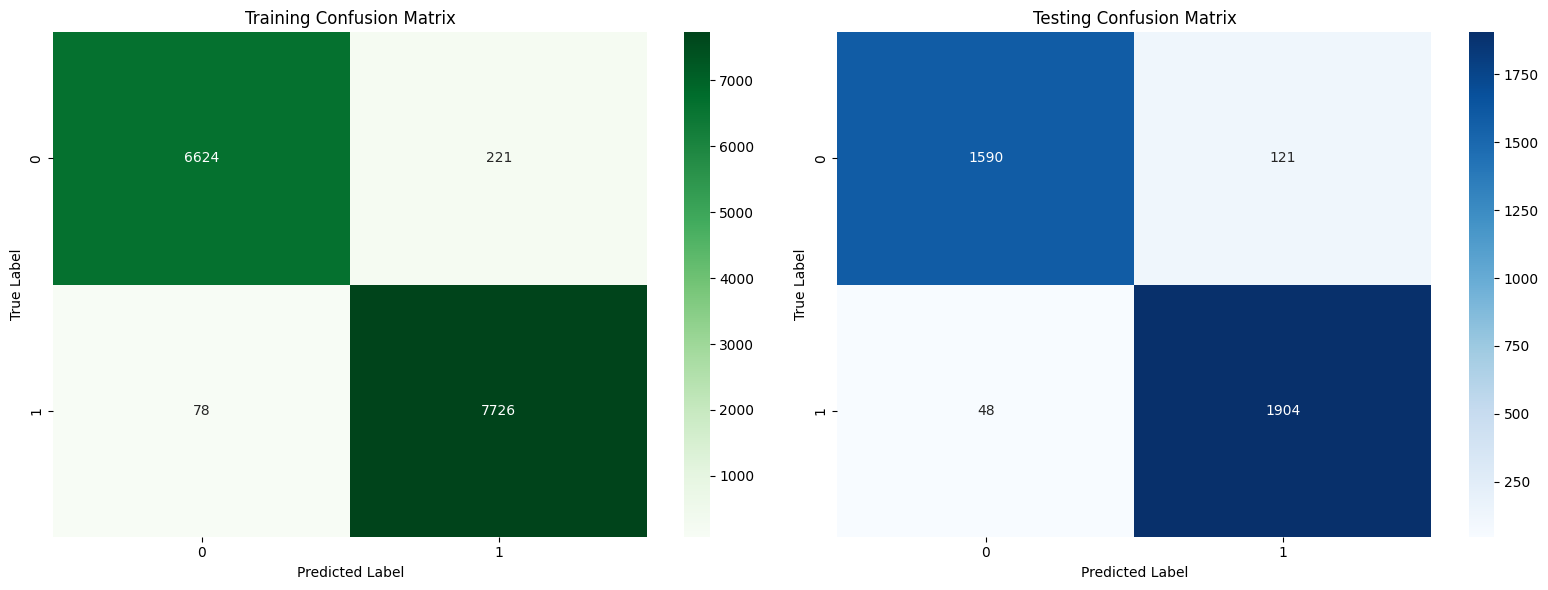

In [19]:
# After your preprocessing code
X_train, X_test, y_train, y_test = prepare_data(X_data, y_labels)

# Create and train model
#input_shape = X_train.shape[1:]  # (channels, height, width)
input_shape = (5, 256,17, 1)
model = create_2dcnn_lstm_model(input_shape)
history = train_model(model, X_train, y_train, X_test, y_test)

# Evaluate model
evaluate_model(model, X_train, y_train, X_test, y_test)

92/92 [==============================] - 19s 204ms/step


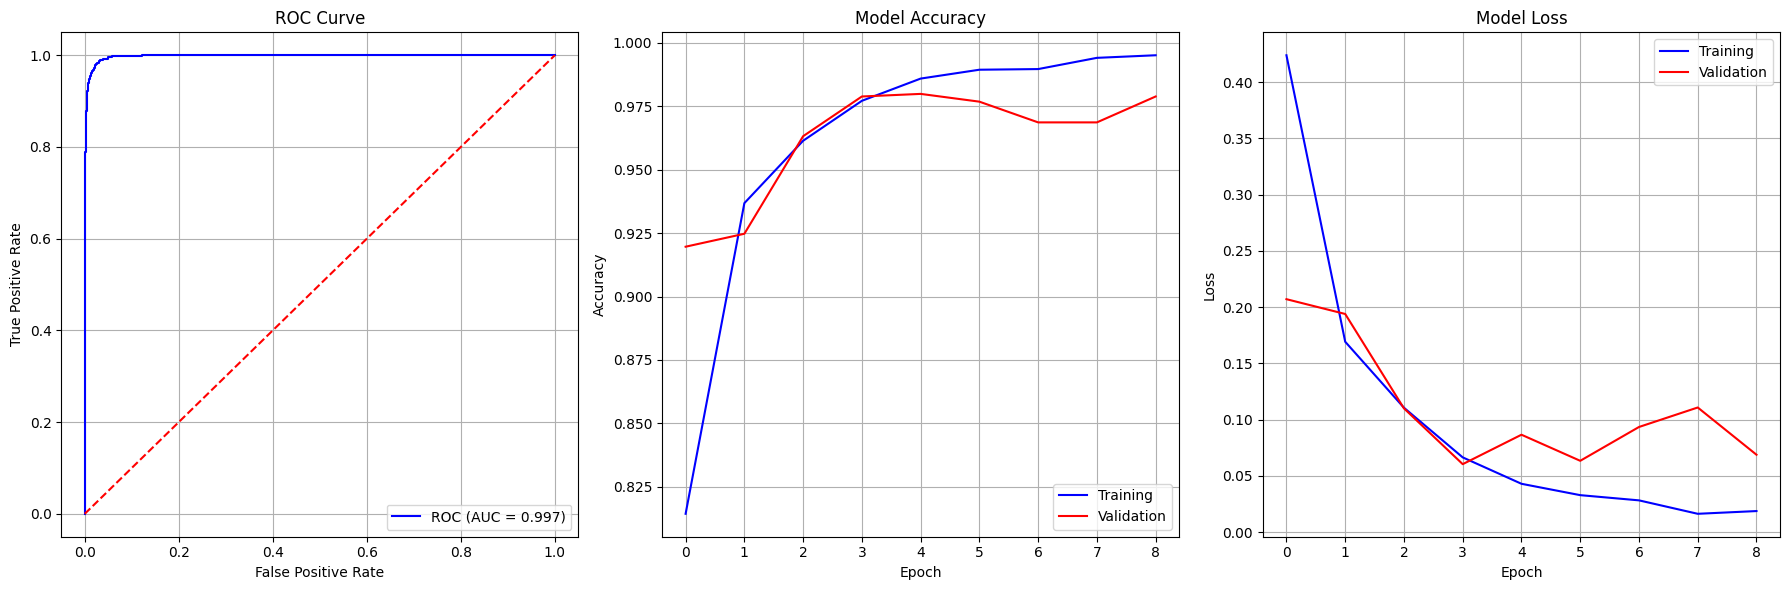

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np


def plot_training_history(history, y_test, X_test, model):
    # Get predictions for ROC curve
    y_pred = model.predict(X_test)
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot 1: ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    axes[0].plot(fpr, tpr, 'b-', label=f'ROC (AUC = {roc_auc:.3f})')
    axes[0].plot([0, 1], [0, 1], 'r--')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC Curve')
    axes[0].legend(loc='lower right')
    axes[0].grid(True)
    
    # Plot 2: Accuracy
    axes[1].plot(history.history['accuracy'], 'b-', label='Training')
    axes[1].plot(history.history['val_accuracy'], 'r-', label='Validation')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Model Accuracy')
    axes[1].legend(loc='lower right')
    axes[1].grid(True)
    
    # Plot 3: Loss
    axes[2].plot(history.history['loss'], 'b-', label='Training')
    axes[2].plot(history.history['val_loss'], 'r-', label='Validation')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Loss')
    axes[2].set_title('Model Loss')
    axes[2].legend(loc='upper right')
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()

# Usage after training
plot_training_history(history, y_test, X_test, model)